Author: SriSaiCharan Velisetti

In [30]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow
import time
from mpl_toolkits import mplot3d
import random
from ast import Lt
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow
%matplotlib inline

# Epipolar Geometry 

## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

In [32]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [33]:
def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code

In [78]:
def getMatrixA(A, B):
    rand_idx = np.random.randint(0, len(A), size=8)
    ''' A = [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]'''

    matrix_A = np.array([(A[0, rand_idx]*B[0, rand_idx]).T, 
                         (A[0, rand_idx]*B[1, rand_idx]).T,
                         (A[0, rand_idx]).T,
                         (A[1, rand_idx]*B[0, rand_idx]).T,
                         (A[1, rand_idx]*B[1, rand_idx]).T,
                         (A[1, rand_idx]).T,
                         (B[0, rand_idx]).T,
                         (B[1, rand_idx]).T,
                         np.ones(8).T]).T
    
    return matrix_A



def normalize(pt):
    """Function to find the transformation to make points zero mean and the variance as sqrt(2)"""
    pt = pt / pt[2]
    pt_mean = np.mean(pt[:2],axis=1)
    S = np.sqrt(2) / np.std(pt[:2])
    T = np.array([[S, 0, -S*pt_mean[0]],
                  [0, S, -S*pt_mean[1]],
                  [0, 0, 1]])
    return T

def computeF(A, B):
    """Function to compute fundamental matrix from corresponding points."""
    
    # Normalize image 1 points
    T_A = normalize(A)
    A = np.dot(T_A, A)
    # Normalize image 2 points
    T_B = normalize(B)
    B = np.dot(T_B, B)

    # matrix_A = getMatrixA(A, B)
    matrix_A = np.array([(A[0, :]*B[0, :]).T, 
                         (A[0, :]*B[1, :]).T,
                         (A[0, :]).T,
                         (A[1, :]*B[0, :]).T,
                         (A[1, :]*B[1, :]).T,
                         (A[1, :]).T,
                         (B[0, :]).T,
                         (B[1, :]).T,
                         np.ones(8).T]).T

    U,S,Vt = np.linalg.svd(matrix_A, full_matrices=True)
    F = Vt.T[:,-1].reshape(3,3)
    u,s,vt = np.linalg.svd(F, full_matrices=True)
    s[2] = 0
    F = np.dot(u, np.dot(np.diag(s), vt))

    # De-normalize F
    F = np.dot(T_B.T, np.dot(F, T_A))
    return F / F[2,2]

def getInliers(pt1, pt2, F, thresh=0.1):
    # Function: implement the criteria checking inliers. 
    l1 = np.dot(F.T, pt2)
    l2 = np.dot(F, pt1)
    d1 = np.diagonal(abs(np.dot(pt1.T, l1)) / np.hypot(l1[0,:], l1[1,:]))
    d2 = np.diagonal(abs(np.dot(pt2.T, l2)) / np.hypot(l2[0,:], l2[1,:]))
    d = d1 +d2
    inlier_idx = np.where(d < 5)

    return inlier_idx

def ransacF(A, B):
    # Find normalization matrix
    # Transform point set 1 and 2
    # RANSAC based 8-point algorithm

    F_final = np.zeros((3,3))
    inlier_idx_final = None
    max_inliers = 0
    for i in range(5000):

        rand_idx = random.sample(range(A.shape[1]), 8)
        F = computeF(A[:,rand_idx], B[:,rand_idx])
        
        # find inliers
        inlier_idx = getInliers(A, B, F, 0.5)
        inlier_count = inlier_idx[0].shape[0]
        
        if inlier_count > max_inliers:
            F_final = F
            inlier_idx_final = inlier_idx

    return F_final, inlier_idx_final


def plot_epipolar_line(img1, img2, F, x1, x2):
    rand_pt_idx = random.sample(range(x1.shape[1]), 7)

    # plot on image 1
    pts1 = x1[:2,rand_pt_idx]
    lines1 = np.dot(F.T, x2)[:,rand_pt_idx]
    
    # plot on image 2
    pts2 = x2[:2,rand_pt_idx]
    lines2 = np.dot(F, x1)[:,rand_pt_idx]

    c = img1.shape[1]
    for i in range(lines1.shape[1]):
        color = (0,255,3)

        x_1, y_1 = map(int, [0, -lines1[2,i] / lines1[1,i]])
        x_2, y_2 = map(int, [c, -(c*lines1[0,i] + lines1[2,i]) / lines1[1,i]])    
        img1 = cv2.line(img1, (x_1, y_1), (x_2, y_2), color,2)
        ptx, pty = pts1.T[i].astype(np.int32)
        img1 = cv2.circle(img1,(ptx, pty),5,(0,0,255),-1)

        X_1, Y_1 = map(int, [0, -lines2[2,i] / lines2[1,i]])
        X_2, Y_2 = map(int, [c, -(c*lines2[0,i] + lines2[2,i]) / lines2[1,i]])        
        img2 = cv2.line(img2, (X_1, Y_1), (X_2, Y_2), color,2)
        Ptx, Pty = pts2.T[i].astype(np.int32)
        img2 = cv2.circle(img2,(Ptx, Pty),5,(0,0,255),-1)

    img_out = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1],3), dtype=np.float32)
    img_out[0:272, 0:512] = img1
    img_out[0:272, 512:512*2] = img2
    cv2_imshow(img_out)

def epilines():
    
    img1 = cv2.imread('/content/Part1_data/chapel00.png')
    img2 = cv2.imread('/content/Part1_data/chapel01.png')
    A = np.concatenate((x1.T, y1.T, np.ones((1, x1.shape[0]))), axis=0)
    B = np.concatenate((x2.T, y2.T, np.ones((1, x2.shape[0]))), axis=0)

    F, inlier_idx = ransacF(A, B)
    print('F:\n',F)

    plot_epipolar_line(img1, img2, F, A, B)




F:
 [[-3.46807785e-06 -5.37628927e-05  9.30512339e-04]
 [ 6.90662014e-05  1.16457508e-05  6.45831239e-02]
 [-5.21306182e-03 -7.57337428e-02  1.00000000e+00]]


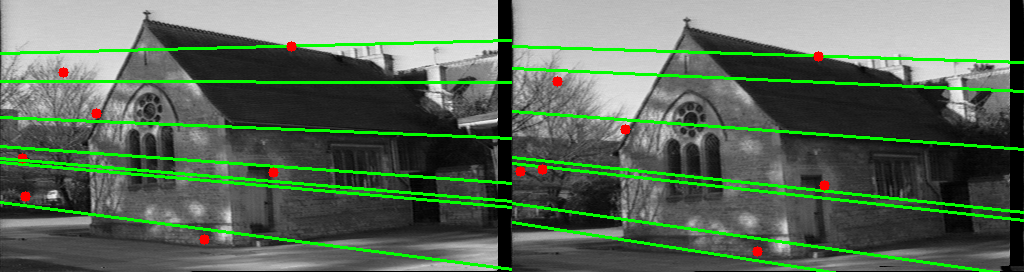

In [90]:
epilines()